In [67]:
import pandas as  pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn import metrics

import math
from rdkit.Chem import AllChem
import rdkit
Chem = rdkit.Chem
from rdkit.Chem import GraphDescriptors
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator, Draw

from sklearn.model_selection import train_test_split

In [4]:
baseall = pd.read_csv('./data/base_all.tsv', sep = '\t')

In [5]:
baseall = baseall.drop_duplicates(subset=['Molecule ChEMBL ID'])

In [6]:
baseall = baseall[['Molecule ChEMBL ID', 'Standard Value', 'Smiles']]

In [7]:
baseall = baseall.rename(columns={'Molecule ChEMBL ID': 'ChEMBL ID', 'Standard Value': 'IC50'})

In [8]:
baseall['Unit'] = 'nM'

In [9]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [10]:
baseall["pIC50"] = baseall.apply(lambda x: round(convert_ic50_to_pic50(x.IC50), 2), axis=1)

In [11]:
# add a column
baseall['active'] = np.zeros(len(baseall))
# label 1 for a molecule with pIC50 >= 6.5, 0 otherwise
baseall.loc[baseall[baseall.pIC50 >= 6.5].index, "active"] = 1.0

In [12]:
def smiles_to_fp(smiles, method = 'maccs', n_bits = 2048):
    mol = Chem.MolFromSmiles(smiles)

    if method == 'maccs':
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    
    if method == 'morgan2':
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius = 2, fsize = n_bits)
        return np.array(fpg.GetFingerprint(mol))

    if method == 'morgan3':
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius = 3, fsize = n_bits)
        return np.array(fpg.GetFingerPrint(mol))

    else:
        return np.array(MACCkeys.GenMACCSKeys(mol))

In [13]:
baseall['fp'] = baseall['Smiles'].apply(smiles_to_fp)
baseall.head()

,ChEMBL ID,IC50,Smiles,Unit,pIC50,active,fp
0,CHEMBL247416,2.0,CC1CC1CNc1cc(C(=O)N[C@@H](Cc2ccccc2)[C@@H](N)C...,nM,8.70,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL429477,66.0,COCCN(C[C@H]1C[C@@H]1C)c1cc(C(=O)N[C@@H](Cc2cc...,nM,7.18,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL393850,279.0,CC1CC1CNc1cc(C(=O)N[C@H](CN)Cc2ccccc2)cc(N(C)S...,nM,6.55,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL1546,100000.0,CC(N)Cc1ccc(O)cc1,nM,4.00,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL502753,1000.0,CC(C)C[C@H](NC(=O)c1cc(C(=O)N[C@H](C)c2ccc(F)c...,nM,6.00,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [14]:
X = baseall['fp']
y = baseall['pIC50']

In [15]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [16]:
X = baseall.fp.tolist()
y = baseall.active.tolist()

In [17]:
X[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

In [20]:
knn = KNeighborsClassifier(n_neighbors=5)

In [21]:
knn.fit(X_train_sc, y_train)
knn.score(X_train_sc, y_train)

0.8591525707586669

In [22]:
knn.score(X_test_sc, y_test)

0.8057602143335566

In [23]:
cross_val_score(knn, X_train_sc, y_train, cv=10).mean()

0.8030500887940258

In [24]:
pred = knn.predict(X_test_sc)

In [25]:
metrics.precision_score(y_test, pred)

0.7685851318944844

In [26]:
metrics.recall_score(y_test, pred)

0.8685636856368564

In [27]:
print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.85      0.74      0.79       755
         1.0       0.77      0.87      0.82       738

    accuracy                           0.81      1493
   macro avg       0.81      0.81      0.81      1493
weighted avg       0.81      0.81      0.81      1493



#### Predict pIC50 values for BACE1 target from list of approved drugs

In [28]:
approved = pd.read_csv('./data/approved.csv')

In [29]:
approved.head(2)

,ChEMBL ID,IC50,Unit,Smiles,pIC50
0,CHEMBL1640,13.0,nM,Cc1cc(-c2ccc(/N=N/c3c(S(=O)(=O)[O-])cc4cc(S(=O...,7.89
1,CHEMBL1201033,4.0,nM,CN(C)/C=N/c1c(I)cc(I)c(CCC(=O)[O-])c1I.[Na+],8.40


In [30]:
approved['fp'] = approved['Smiles'].apply(smiles_to_fp)

In [31]:
X_app = baseall['fp']
y_app = baseall['pIC50']

In [34]:
X_app = baseall.fp.tolist()
y_app = baseall.active.tolist()

In [35]:
X_app_sc = sc.transform(X_test)

In [40]:
approved_predictions = knn.predict(X_app_sc)

In [50]:
approved_prediction_pIC50 = pd.DataFrame(approved_predictions, columns = ['BACE1_pIC50'])
approved_prediction_pIC50_df = approved.join(approved_prediction_pIC50)

In [57]:
approved_prediction_pIC50_df.sample(3)

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fp,BACE1_pIC50
1542,CHEMBL547,937.0,nM,CC1=C(/C=C/C(C)=C/C=C/C(C)=C\C(=O)O)C(C)(C)CCC1,6.03,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
1163,CHEMBL1657,113.0,nM,CCOC(=O)c1ccc(C#Cc2ccc3c(c2)C(C)(C)CCS3)nc1,6.95,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
117,CHEMBL14376,57.0,nM,COc1cc(C(C)=O)ccc1OCCCN1CCC(c2noc3cc(F)ccc23)CC1,7.24,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [54]:
approved_prediction_pIC50_df = approved_prediction_pIC50_df.sort_values(by='BACE1_pIC50', ascending = True)
approved_prediction_pIC50_df

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fp,BACE1_pIC50
844,CHEMBL4297528,59.0,nM,Cc1cn2nc(-c3cc(=O)n4cc(N5CCNC6(CC6)C5)ccc4n3)c...,7.23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
73,CHEMBL1201202,1.0,nM,CO[C@H]1O[C@H](COS(=O)(=O)O)[C@@H](O[C@@H]2O[C...,9.00,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1461,CHEMBL688,34.0,nM,CCC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1.O=C(O)C...,7.47,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
82,CHEMBL3301622,350.0,nM,CCc1nc(C(N)=O)c(Nc2ccc(N3CCC(N4CCN(C)CC4)CC3)c...,6.46,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
83,CHEMBL657,976.0,nM,CN(C)CCOC(c1ccccc1)c1ccccc1,6.01,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...,...,...,...
2047,CHEMBL1692,206.0,nM,CN(C)CCCN1c2ccccc2CCc2ccccc21.Cl,6.69,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
2048,CHEMBL563,966.0,nM,CC(C(=O)O)c1ccc(-c2ccccc2)c(F)c1,6.02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
2049,CHEMBL812,103.0,nM,CN(C)C(=O)Oc1ccc[n+](C)c1.[Br-],6.99,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN
2050,CHEMBL1115,86.0,nM,CN(C)C(=O)Oc1ccc[n+](C)c1,7.07,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",NaN


In [58]:
# bottom 5 molecules
bottom5_drugs = approved_prediction_pIC50_df[500:505]
bottom5_drugs

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fp,BACE1_pIC50
582,CHEMBL21731,741.0,nM,CNCCCC12CCC(c3ccccc31)c1ccccc12,6.13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
775,CHEMBL1201020,32.0,nM,CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C.O=P...,7.49,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1162,CHEMBL1200636,132.0,nM,CN(C)CCC=C1c2ccccc2C=Cc2ccccc21.Cl,6.88,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1167,CHEMBL2360079,9.0,nM,CC(=O)c1ccc2c(c1)N(CCCN1CCN(CCO)CC1)c1ccccc1S2...,8.05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
774,CHEMBL1200464,26.0,nM,CCCOc1ccc(C(=O)OCCN(CC)CC)cc1N.Cl,7.59,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


In [59]:
approved_prediction_pIC50_df['BACE1_pIC50'].describe()

count    1493.000000
mean        0.558607
std         0.496720
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: BACE1_pIC50, dtype: float64

In [62]:
approved_prediction_pIC50_df = approved_prediction_pIC50_df.loc[approved_prediction_pIC50_df['BACE1_pIC50'] >= 1]

In [63]:
approved_prediction_pIC50_df.shape

(834, 7)

In [65]:
top5_drugs = approved_prediction_pIC50_df[1:5]
top5_drugs

,ChEMBL ID,IC50,Unit,Smiles,pIC50,fp,BACE1_pIC50
150,CHEMBL1200991,14.0,nM,CC1(C)S[C@@H]2[C@H](NC(=O)C(C(=O)Oc3ccc4c(c3)C...,7.85,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",1.0
148,CHEMBL1138,272.0,nM,O=C1[C@H](CC[C@H](O)c2ccc(F)cc2)[C@@H](c2ccc(O...,6.57,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...",1.0
139,CHEMBL3989559,2.0,nM,COc1ccnc(C[S+]([O-])c2nc3cc(OC(F)F)ccc3[n-]2)c...,8.70,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0
143,CHEMBL1774461,50.0,nM,CNc1ccc(/C=C/c2ccc(OCCOCCOCC[18F])nc2)cc1,7.30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.0


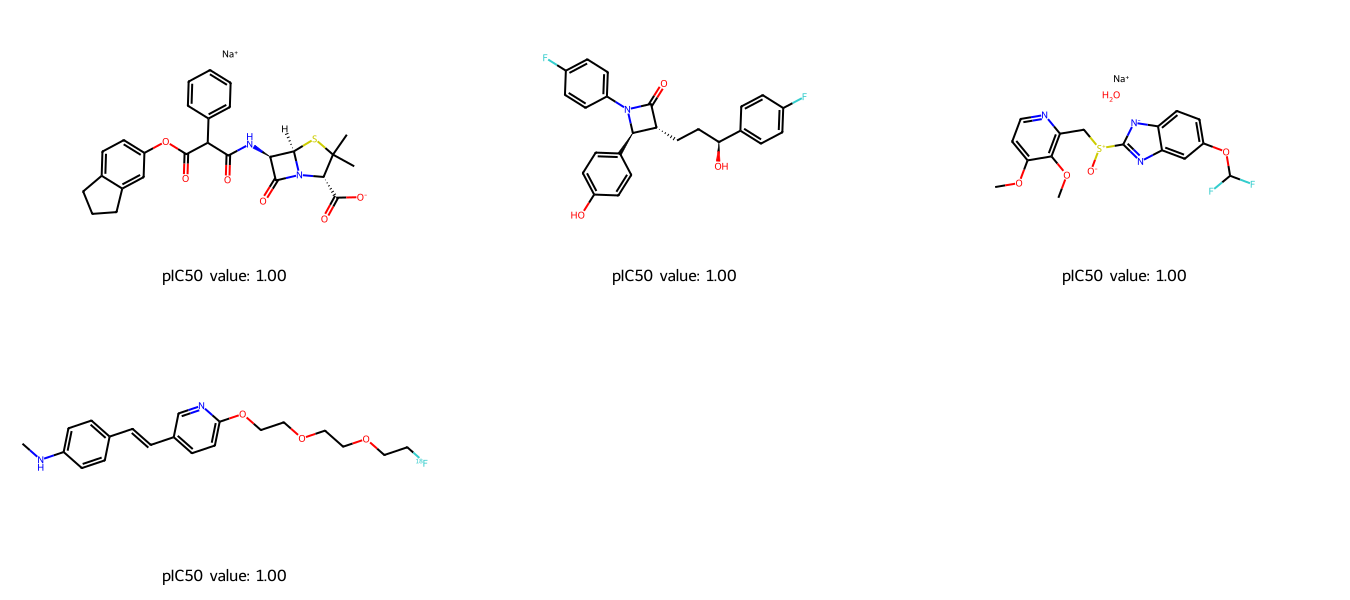

In [68]:
top5_pIC50 = approved_prediction_pIC50_df['Smiles'][top5_drugs.index]
mols_base = [Chem.MolFromSmiles(smile) for smile in top5_pIC50]
pIC50_base = top5_drugs["BACE1_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_base]
Draw.MolsToGridImage(mols_base, molsPerRow = 3, subImgSize=(450, 300), legends=pIC50_values)